In [1]:
# Third Party Imports
import glob
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import os
import pickle
from exphelperfunctions import abbrv_num
from exphelperfunctions import objectToFile
from exphelperfunctions import objectFromFile
from exphelperfunctions import add_value_labels

## Load original data

In [3]:
dirpath = "/mnt/h/CICIDS/2017/"
filepaths = [dirpath+f for f in os.listdir(dirpath) if f.endswith('.csv')]

In [4]:
#Open CICIDS2017
print(filepaths)

df = pd.concat(map(lambda file: pd.read_csv(file, sep=',',header=0,skipinitialspace=True, encoding='cp1252'), filepaths), ignore_index=True)
df = df.dropna()
df = df.reset_index(drop=True)

['/mnt/h/CICIDS/2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Friday-WorkingHours-Morning.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Monday-WorkingHours.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Tuesday-WorkingHours.pcap_ISCX.csv', '/mnt/h/CICIDS/2017/Wednesday-workingHours.pcap_ISCX.csv']


/home/arjen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


In [5]:
df.sort_values(by='Timestamp', inplace=True)

In [6]:
print(df.columns)
print(df['Label'].unique())

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
  

In [7]:
#Add binary label

df['BinLabel'] = np.where(df['Label'] == 'BENIGN', 'Benign','Malicious')
print(df['BinLabel'].value_counts())
print(df['Label'].value_counts())

Benign       2272688
Malicious     556697
Name: BinLabel, dtype: int64
BENIGN                        2272688
DoS Hulk                       230124
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack – Brute Force         1507
Web Attack – XSS                  652
Infiltration                       36
Web Attack – Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64


## Data composition
Total: 2,829,385 instances

Normal: 2,272,688 instances (80.3%)

Malicious: 556,697 instances (19.7%)

## One hot encoding

In [8]:
print(df['Protocol'].value_counts())

6.0     1828196
17.0     999493
0.0        1696
Name: Protocol, dtype: int64


In [9]:
# One hot encoding for protocol
ohe_df = pd.get_dummies(df['Protocol'], prefix="proto")
df = df.join(ohe_df)

In [10]:
print(df.columns)

Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
  

# Random Forest: Select features and split data

In [12]:
#Get input columns and corresponding label vector
#Use duration, protocol, src bytes&packets per flow, dst bytes&packets per flow, mean src/dst bytes per flow, mean IAT src/dst per flow
#features = ['Flow Duration','proto_0.0','proto_6.0','proto_17.0','Total Length of Fwd Packets','Total Length of Bwd Packets','Fwd Packet Length Mean','Bwd Packet Length Mean','Total Fwd Packets','Total Backward Packets','Fwd IAT Mean','Bwd IAT Mean']
#ullah features to confirm their results
features = ['Source Port', 'Destination Port', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Min', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Init_Win_bytes_forward', 'act_data_pkt_fwd']
label = 'BinLabel'
skf = StratifiedKFold(n_splits=5)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = []
for train_idxs, test_idxs in skf.split(df[features], df['Label']):
    print("TRAIN:", (len(train_idxs)), "TEST:", (len(test_idxs)))
    X_train = df[features].iloc[train_idxs,:]
    X_test = df[features].iloc[test_idxs,:]
    y_train = df[label].iloc[train_idxs]
    y_test = df[label].iloc[test_idxs]
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=9)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 2263508 TEST: 565877


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    5.3s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   12.4s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.7s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   32.5s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   45.1s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   50.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


TRAIN: 2263508 TEST: 565877


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    5.6s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   13.0s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.9s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   32.5s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   46.4s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   51.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


TRAIN: 2263508 TEST: 565877


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    5.2s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   12.6s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   21.9s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   33.0s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   46.3s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   52.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


TRAIN: 2263508 TEST: 565877


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    6.1s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   14.2s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   23.0s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   35.6s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   49.2s


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   55.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


TRAIN: 2263508 TEST: 565877


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100

building tree 5 of 100


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    5.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   12.9s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.6s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   32.2s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:   46.7s


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   51.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.5s finished


In [14]:
print(cfs)
cf = np.mean(cfs,axis=(0))
cf_std = np.std(cfs,axis=0)
print(cf)
print(cf_std)
#objectToFile(preds, "cicids2017_preds_"+label)

[array([[454359,    179],
       [   329, 111010]]), array([[453925,    613],
       [   122, 111217]]), array([[454393,    145],
       [   768, 110571]]), array([[453301,   1236],
       [   134, 111206]]), array([[453658,    879],
       [  1343, 109997]])]
[[453927.2    610.4]
 [   539.2 110800.2]]
[[416.65832525 416.22859104]
 [464.94533012 464.77409566]]


In [15]:
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

std. dev %
 [[ 1.01442512 82.33815251]
 [60.31586267  3.57215347]]


In [3]:
#Load object from file
from sklearn.metrics import confusion_matrix
label='BinLabel'
preds_mem = objectFromFile("cicids2017_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

In [4]:
cf = np.mean(cfs,axis=(0))
print(cf)

[[449006.    5531.6]
 [  6225.6 105113.8]]


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.999
paper2_acc = 1.0
paper2_rec = 1.0
paper2_spec = 1.0
#tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
#print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
#rec_score  = tp / (tp+fn)
#spec_score = tn / (tn+fp)
#acc_scores = [0.997]
rec_score = 0.991
spec_score = 0.999
print(np.mean(acc_scores), "\n")
print(rec_score, "\n")
print(spec_score)

0.9979684631112414 

0.991 

0.999


/home/arjen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


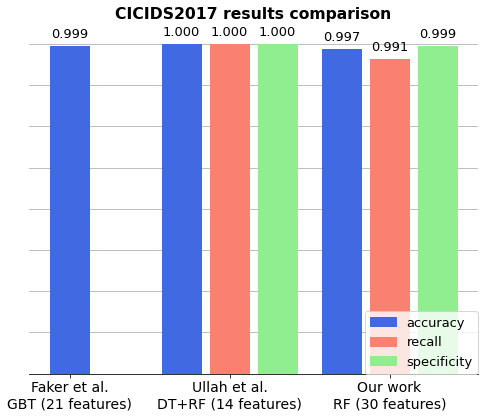

In [11]:
import matplotlib.patches as mpatches
#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['Faker et al.\nGBT (21 features)', 'Ullah et al.\nDT+RF (14 features)', 'Our work\nRF (30 features)']
x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [paper1_acc,paper2_acc,paper2_rec,paper2_spec,np.mean(acc_scores),rec_score,spec_score]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0], height=scores[0], width=width, color=clr_acc)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width, height=scores[1], width=width, color=clr_acc)
plt.bar(x[1], height=scores[2], width=width, color=clr_rec)
plt.bar(x[1]+pad_width, height=scores[3], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[4], width=width, color=clr_acc)
plt.bar(x[2], height=scores[5], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[6], width=width, color=clr_spec)

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
ax.set_xticklabels(labels)
#plt.ylabel('Metric score')
#plt.yticks(size='14')
plt.xticks(size='14')
plt.ylim([0.8, 1])
ax.set_yticklabels([])
plt.title("CICIDS2017 results comparison", fontweight='bold',  pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
ax.legend(handles=[acc_patch,rec_patch,spec_patch], loc='lower right', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y')
fig.tight_layout()
plt.savefig('cicids2017_binaryclass_bars.png',bbox_inches='tight')
plt.show()

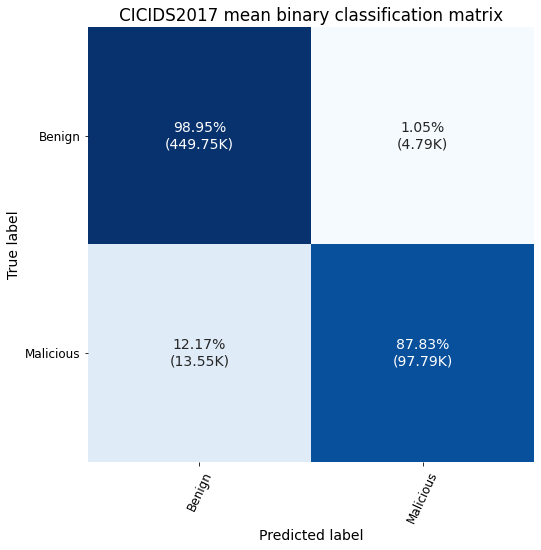

In [22]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
column_labels = sorted(y_test.unique())
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("CICIDS2017 mean binary classification matrix")
plt.savefig('cicids2017_binaryclass_cf.png',bbox_inches='tight')
plt.show()

In [29]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: Bwd Packet Length Mean, Score: 0.20128
Feature: Total Length of Bwd Packets, Score: 0.15678
Feature: Total Length of Fwd Packets, Score: 0.14350
Feature: Fwd Packet Length Mean, Score: 0.09847
Feature: Total Backward Packets, Score: 0.07127
Feature: Fwd IAT Mean, Score: 0.06978
Feature: proto_6.0, Score: 0.06395
Feature: Total Fwd Packets, Score: 0.06379
Feature: Flow Duration, Score: 0.06044
Feature: proto_17.0, Score: 0.04380
Feature: Bwd IAT Mean, Score: 0.02656
Feature: proto_0.0, Score: 0.00038


In [47]:
#Depth hyper parameter check
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
train_scores, test_scores, train_bacc_scores, test_bacc_scores = list(), list(), list(), list()
#Split in train and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)
depth_values = range(100, 600, 100)
for d in depth_values:
    #Make model
    clf = RandomForestClassifier(n_estimators=d,min_samples_split=10,min_samples_leaf=5,max_samples=0.7,criterion='entropy',n_jobs=4)
    #Fit on training split
    clf.fit(X_train,y_train)
    #evaluate on train
    ytrain_pred = clf.predict(X_train)
    train_bacc = balanced_accuracy_score(y_train,ytrain_pred)
    train_rec = recall_score(y_train,ytrain_pred, average='weighted')
    train_bacc_scores.append(train_bacc)
    train_scores.append(train_rec)
    #evaluate on test
    ytest_pred = clf.predict(X_test)
    test_bacc = balanced_accuracy_score(y_test,ytest_pred)
    test_rec = recall_score(y_test,ytest_pred,average='weighted')
    test_bacc_scores.append(test_bacc)
    test_scores.append(test_rec)
    #Print progress
    print('>%.1f, train: %.3f, test: %.3f' % (d, train_bacc, test_bacc))


>100.0, train: 0.979, test: 0.976
>200.0, train: 0.979, test: 0.976
>300.0, train: 0.979, test: 0.976
>400.0, train: 0.979, test: 0.976
>500.0, train: 0.979, test: 0.976


5-fold binary test results:

[array([[450308,   4230],
       [   427, 110912]]), array([[449702,   4836],
       [   257, 111082]]), array([[447660,   6878],
       [ 29521,  81818]]), array([[447815,   6722],
       [ 10480, 100860]]), array([[453386,   1151],
       [ 27591,  83749]])]

Mean:

[[449774.2   4763.4]
 [ 13655.2  97684.2]]
 
Std. Dev:
 
[[ 2080.55573345  2080.71464646]
 [12731.92102395 12731.75199884]]

In [17]:
import itertools
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
fold_val_bacc = []
for train_idx, test_idx in skf.split(df[features], df['Label']):
    #Split train into train/val
    split_idx = math.floor(len(train_idx)*0.75)
    val_idx = train_idx[split_idx:]
    train_idx = train_idx[:split_idx]
    print("TRAIN:", len(train_idx), "VAL:", len(val_idx), "TEST:", len(test_idx))
    #Get train / val / test split data
    X_train = df[features].iloc[train_idx,:]
    X_val = df[features].iloc[val_idx,:]
    X_test = df[features].iloc[test_idx,:]
    y_train = df[label].iloc[train_idx]
    y_val = df[label].iloc[val_idx]
    y_test = df[label].iloc[test_idx]
    #Apply Random Forest
    measure_search = ['gini','entropy']
    size_search = [1,5,10,25,50,100]
    msamples_search = [0.7, 0.8, 0.9]
    val_bacc_scores = list()
    for (c, n, maxs) in [(c, n, maxs) for c in measure_search for n in size_search for maxs in msamples_search]:
        print("Working on grid: ", c, n, maxs)
        clf = RandomForestClassifier(n_estimators=n,min_samples_split=10,min_samples_leaf=5,max_samples=maxs,criterion=c,n_jobs=5)
        clf.fit(X_train,y_train)
        print("Finished building random forest")
        #evaluate on val
        yval_pred = clf.predict(X_val)
        val_bacc = balanced_accuracy_score(y_val,yval_pred)
        val_bacc_scores.append(val_bacc)
        #Print progress
        print('{%s,%.1f,%.1f} val: %.3f' % (c, n, maxs, val_bacc))
    #fold_train_bacc.append(train_bacc_scores)
    fold_val_bacc.append(val_bacc_scores)

TRAIN: 1697631 VAL: 565877 TEST: 565877
Working on grid:  gini 1 0.7
Finished building random forest
{gini,1.0,0.7} val: 0.811
Working on grid:  gini 1 0.8
Finished building random forest
{gini,1.0,0.8} val: 0.814
Working on grid:  gini 1 0.9
Finished building random forest
{gini,1.0,0.9} val: 0.805
Working on grid:  gini 5 0.7
Finished building random forest
{gini,5.0,0.7} val: 0.812
Working on grid:  gini 5 0.8
Finished building random forest
{gini,5.0,0.8} val: 0.804
Working on grid:  gini 5 0.9
Finished building random forest
{gini,5.0,0.9} val: 0.810
Working on grid:  gini 10 0.7
Finished building random forest
{gini,10.0,0.7} val: 0.801
Working on grid:  gini 10 0.8
Finished building random forest
{gini,10.0,0.8} val: 0.811
Working on grid:  gini 10 0.9
Finished building random forest
{gini,10.0,0.9} val: 0.810
Working on grid:  gini 25 0.7
Finished building random forest
{gini,25.0,0.7} val: 0.807
Working on grid:  gini 25 0.8
Finished building random forest
{gini,25.0,0.8} val:

{gini,100.0,0.8} val: 0.828
Working on grid:  gini 100 0.9
Finished building random forest
{gini,100.0,0.9} val: 0.828
Working on grid:  entropy 1 0.7
Finished building random forest
{entropy,1.0,0.7} val: 0.706
Working on grid:  entropy 1 0.8
Finished building random forest
{entropy,1.0,0.8} val: 0.823
Working on grid:  entropy 1 0.9
Finished building random forest
{entropy,1.0,0.9} val: 0.668
Working on grid:  entropy 5 0.7
Finished building random forest
{entropy,5.0,0.7} val: 0.832
Working on grid:  entropy 5 0.8
Finished building random forest
{entropy,5.0,0.8} val: 0.823
Working on grid:  entropy 5 0.9
Finished building random forest
{entropy,5.0,0.9} val: 0.828
Working on grid:  entropy 10 0.7
Finished building random forest
{entropy,10.0,0.7} val: 0.823
Working on grid:  entropy 10 0.8
Finished building random forest
{entropy,10.0,0.8} val: 0.831
Working on grid:  entropy 10 0.9
Finished building random forest
{entropy,10.0,0.9} val: 0.825
Working on grid:  entropy 25 0.7
Finis

Finished building random forest
{entropy,100.0,0.7} val: 0.500
Working on grid:  entropy 100 0.8
Finished building random forest
{entropy,100.0,0.8} val: 0.500
Working on grid:  entropy 100 0.9
Finished building random forest
{entropy,100.0,0.9} val: 0.500


In [18]:
a = np.mean(fold_val_bacc,axis=0)
print(a.reshape(2,6,3))

[[[0.77073232 0.82016667 0.7316449 ]
  [0.77124748 0.76074876 0.75862805]
  [0.75988701 0.76118935 0.76069278]
  [0.76085267 0.76048265 0.76108138]
  [0.76035533 0.76052673 0.75954823]
  [0.76110214 0.76165362 0.76074162]]

 [[0.73269448 0.79511023 0.73772687]
  [0.75844146 0.75871192 0.75880961]
  [0.75895715 0.76031716 0.75688124]
  [0.76013173 0.75892063 0.76003531]
  [0.75945564 0.75988665 0.75983702]
  [0.76034389 0.76009785 0.76034331]]]


# N-grams experiment

### Show amount of source IPs with more than 'threshold' flows

In [11]:
threshold = 2
vc = df['Source IP'].value_counts()
res = df[df['Source IP'].isin(vc[vc>threshold].index)]['Source IP'].value_counts()
print(res)

172.16.0.1        558298
192.168.10.3      298975
192.168.10.8      215273
192.168.10.5      170102
192.168.10.9      152531
                   ...  
23.211.102.137         3
81.222.128.13          3
27.221.30.47           3
52.200.141.101         3
54.88.226.64           3
Name: Source IP, Length: 11634, dtype: int64


Threshold (#flows+1) | #Source IPs
--- | ---
0 | 17005
1 | 14054
2 | 11634
3 | 10178

### Transform interesting features to N-gram representation

In [14]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
            'Flow IAT Max', 'Flow IAT Min']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'ngram_' + feature + '_mean'
    column_std = 'ngram_' + feature + '_std'
    if column_mean not in df.columns:
        df[column_mean] = np.nan
    if column_std not in df.columns:
        df[column_std] = np.nan

#List of ngram features
featurelist = df.filter(regex='^ngram', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res.iteritems()):
    sub_df = df[df['Source IP'] == srcIP]
    for feature in features:
        column_mean = 'ngram_' + feature + '_mean'
        column_std = 'ngram_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df.loc[:,featurelist] = df[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res)), end='\r')
    
    

In [15]:
df

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,ngram_Flow Packets/s_mean,ngram_Flow Packets/s_std,ngram_Flow IAT Mean_mean,ngram_Flow IAT Mean_std,ngram_Flow IAT Std_mean,ngram_Flow IAT Std_std,ngram_Flow IAT Max_mean,ngram_Flow IAT Max_std,ngram_Flow IAT Min_mean,ngram_Flow IAT Min_std
896292,192.168.10.25-23.194.182.12-59385-443-6,192.168.10.25,59385.0,23.194.182.12,443.0,6.0,03/07/2017 01:00:01,83823.0,10.0,5.0,...,166726.342586,288623.467589,4.808416e+06,8.323232e+06,1.270680e+07,2.200088e+07,3.362363e+07,5.821747e+07,3.333333,0.577350
899991,192.168.10.1-192.168.10.3-53-61098-17,192.168.10.3,61098.0,192.168.10.1,53.0,17.0,03/07/2017 01:00:01,86739.0,1.0,1.0,...,47.112876,21.744539,5.171133e+04,3.054813e+04,0.000000e+00,0.000000e+00,5.171133e+04,3.054813e+04,51711.333333,30548.130652
896293,192.168.10.25-23.194.182.12-59385-443-6,23.194.182.12,443.0,192.168.10.25,59385.0,6.0,03/07/2017 01:00:01,3.0,2.0,0.0,...,448849.730788,377269.999691,3.983333e+01,6.379720e+01,3.276261e+01,5.674651e+01,6.300000e+01,1.039230e+02,16.666667,23.671361
1130417,192.168.10.3-192.168.10.25-53-51147-17,192.168.10.25,51147.0,192.168.10.3,53.0,17.0,03/07/2017 01:00:01,100934792.0,4.0,4.0,...,388888.915309,346944.288824,4.806421e+06,8.324959e+06,1.270374e+07,2.200353e+07,3.361579e+07,5.822426e+07,3.333333,0.577350
897095,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,03/07/2017 01:00:01,118699862.0,76.0,0.0,...,0.878880,0.207151,1.201286e+06,3.306139e+05,2.909551e+06,4.780802e+05,1.582930e+07,8.860682e+05,0.333333,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561076,192.168.10.5-72.247.71.166-50380-443-6,192.168.10.5,50380.0,72.247.71.166,443.0,6.0,7/7/2017 9:59,116344944.0,23.0,21.0,...,0.360725,0.089456,2.924479e+06,6.369627e+05,4.468447e+06,2.646083e+05,1.000000e+07,1.171004e+01,48.333333,80.274529
561075,192.168.10.5-23.203.114.64-50375-443-6,192.168.10.5,50375.0,23.203.114.64,443.0,6.0,7/7/2017 9:59,116435508.0,26.0,23.0,...,0.351643,0.088171,2.995580e+06,6.117358e+05,7.235976e+06,4.738977e+06,2.610000e+07,2.788602e+07,47.666667,80.845532
561074,172.217.10.46-192.168.10.5-80-50374-6,192.168.10.5,50374.0,172.217.10.46,80.0,6.0,7/7/2017 9:59,116543999.0,18.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561084,172.217.10.4-192.168.10.5-443-50397-6,192.168.10.5,50397.0,172.217.10.4,443.0,6.0,7/7/2017 9:59,119678976.0,20.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Save to feathered file

In [18]:
df_feather_path = "/mnt/h/CICIDS/2017/feather/trigram_feather"
df.reset_index().to_feather(df_feather_path)

In [6]:
df_feather_path = "/mnt/h/CICIDS/2017/feather/trigram_feather"
df = pd.read_feather(df_feather_path)

## Build Random Forest with ngram features

In [7]:
#Drop rows without ngram features
df.dropna(subset=df.filter(regex='^ngram', axis=1).columns, axis=0, how='any', inplace=True)
print(df.shape)
print(df.filter(regex='^ngram', axis=1).columns)

(2794030, 120)
Index(['ngram_Flow Duration_mean', 'ngram_Flow Duration_std',
       'ngram_Total Fwd Packets_mean', 'ngram_Total Fwd Packets_std',
       'ngram_Total Backward Packets_mean', 'ngram_Total Backward Packets_std',
       'ngram_Total Length of Fwd Packets_mean',
       'ngram_Total Length of Fwd Packets_std',
       'ngram_Total Length of Bwd Packets_mean',
       'ngram_Total Length of Bwd Packets_std',
       'ngram_Fwd Packet Length Max_mean', 'ngram_Fwd Packet Length Max_std',
       'ngram_Fwd Packet Length Min_mean', 'ngram_Fwd Packet Length Min_std',
       'ngram_Bwd Packet Length Max_mean', 'ngram_Bwd Packet Length Max_std',
       'ngram_Bwd Packet Length Min_mean', 'ngram_Bwd Packet Length Min_std',
       'ngram_Flow Bytes/s_mean', 'ngram_Flow Bytes/s_std',
       'ngram_Flow Packets/s_mean', 'ngram_Flow Packets/s_std',
       'ngram_Flow IAT Mean_mean', 'ngram_Flow IAT Mean_std',
       'ngram_Flow IAT Std_mean', 'ngram_Flow IAT Std_std',
       'ngram_Flow IA

In [10]:
# Compare ngram feature set to normal feature set
features = df.filter(regex='^ngram', axis=1).columns
#features = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', \
#            'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', \
#            'Fwd Packet Length Min', 'Bwd Packet Length Max', 'Bwd Packet Length Min', \
#            'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', \
#            'Flow IAT Max', 'Flow IAT Min']
features = features.append(df[['Source Port', 'Destination Port']].columns)

label = 'BinLabel'
skf = StratifiedKFold(n_splits=5)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = []
for train_idxs, test_idxs in skf.split(df[features], df['Label']):
    print("TRAIN:", (len(train_idxs)), "TEST:", (len(test_idxs)))
    X_train = df[features].iloc[train_idxs,:]
    X_test = df[features].iloc[test_idxs,:]
    y_train = df[label].iloc[train_idxs]
    y_test = df[label].iloc[test_idxs]
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=9)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 2235224 TEST: 558806


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100


building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   15.3s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   37.9s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.7min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  2.4min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished


TRAIN: 2235224 TEST: 558806


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100



building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   16.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   43.3s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.2min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.8min


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  2.5min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished


TRAIN: 2235224 TEST: 558806


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100

building tree 4 of 100building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   16.4s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   37.9s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.7min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  2.3min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished


TRAIN: 2235224 TEST: 558806


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   14.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   35.5s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.7min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  2.5min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  2.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished


TRAIN: 2235224 TEST: 558806


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   15.4s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   39.4s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.8min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100


[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  2.6min


building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    0.6s finished


In [12]:
print(cfs)
cf = np.mean(cfs,axis=(0))
cf_std = np.std(cfs,axis=0)
print(cf)
print(cf_std)
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)
objectToFile(preds, "cicids2017_trigrams_ports_preds_"+label)

[array([[447543,      9],
       [   259, 110995]]), array([[447549,      3],
       [    98, 111156]]), array([[447520,     32],
       [   560, 110694]]), array([[446563,    988],
       [   145, 111110]]), array([[446990,    561],
       [   968, 110287]])]
[[4.472330e+05 3.186000e+02]
 [4.060000e+02 1.108484e+05]]
[[396.55365337 396.09322135]
 [323.77584839 323.59023471]]
std. dev %
 [[8.86682453e-02 1.24323045e+02]
 [7.97477459e+01 2.91921430e-01]]


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
label = 'BinLabel'
preds_mem = objectFromFile("cicids2017_trigrams_normal_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

### Ngram results

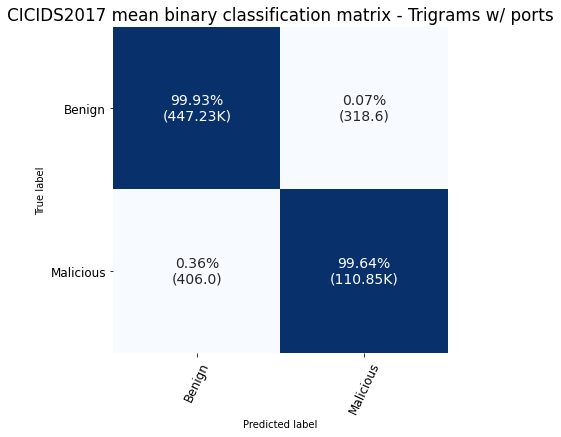

In [13]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6, 6))
plt.rc('font', size=14)
#column_labels = sorted(y_test.unique())
#column_labels[0] = 'Benign'
#column_labels[3] = 'DoS-GE'
#column_labels[4] = 'DoS-Hulk'
#column_labels[5] = 'DoS-SHT'
#column_labels[6] = 'DoS-SL'
#column_labels[12] = 'WA-BruteForce'
#column_labels[13] = 'WA-SQLInject'
#column_labels[14] = 'WA-XSS'
column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("CICIDS2017 mean binary classification matrix - Trigrams w/ ports")
plt.savefig('cicids2017_binaryclass_cf_trigrams_ports.png',bbox_inches='tight')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

447233.0 318.6 406.0 110848.4
Accuracy: 0.9987033066931994 

Recall: 0.9963507061293756 

Specificity: 0.9992881267768902


In [27]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: ngram_Fwd Packet Length Min_std, Score: 0.15939
Feature: ngram_Bwd Packet Length Min_std, Score: 0.13067
Feature: ngram_Bwd Packet Length Max_mean, Score: 0.11131
Feature: ngram_Fwd Packet Length Max_std, Score: 0.05638
Feature: ngram_Total Length of Bwd Packets_std, Score: 0.05282
Feature: ngram_Total Backward Packets_std, Score: 0.05257
Feature: ngram_Bwd Packet Length Max_std, Score: 0.04286
Feature: ngram_Total Length of Bwd Packets_mean, Score: 0.03823
Feature: ngram_Fwd Packet Length Min_mean, Score: 0.03772
Feature: ngram_Flow IAT Max_mean, Score: 0.03758
Feature: ngram_Total Length of Fwd Packets_std, Score: 0.03220
Feature: ngram_Total Length of Fwd Packets_mean, Score: 0.02546
Feature: ngram_Bwd Packet Length Min_mean, Score: 0.02431
Feature: ngram_Fwd Packet Length Max_mean, Score: 0.02127
Feature: ngram_Flow Bytes/s_std, Score: 0.02110
Feature: ngram_Flow Packets/s_mean, Score: 0.02035
Feature: ngram_Total Backward Packets_mean, Score: 0.02034
Feature: ngram_Flow I

### Normal feature set results

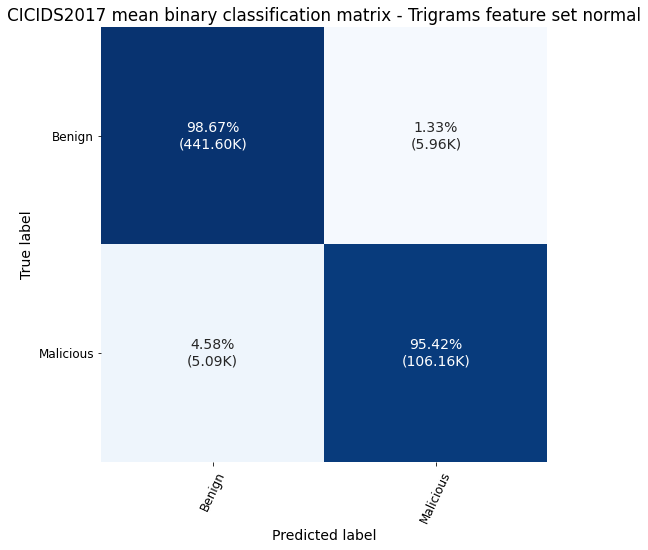

In [30]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(8, 8))
plt.rc('font', size=14)
column_labels = sorted(y_test.unique())
#column_labels[0] = 'Benign'
#column_labels[3] = 'DoS-GE'
#column_labels[4] = 'DoS-Hulk'
#column_labels[5] = 'DoS-SHT'
#column_labels[6] = 'DoS-SL'
#column_labels[12] = 'WA-BruteForce'
#column_labels[13] = 'WA-SQLInject'
#column_labels[14] = 'WA-XSS'
#column_labels = ['Benign', 'Malicious']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0', size='12')
plt.xticks(rotation='65', size='12')
plt.title("CICIDS2017 mean binary classification matrix - Trigrams feature set normal")
plt.savefig('cicids2017_binaryclass_cf_trigrams_normal.png',bbox_inches='tight')
plt.show()

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

441603.2 5957.8 5092.4 106160.2
Accuracy: 0.9802256009260256 

Recall: 0.9542266877358372 

Specificity: 0.9866882950033627


## Construct barplot of own feature sets

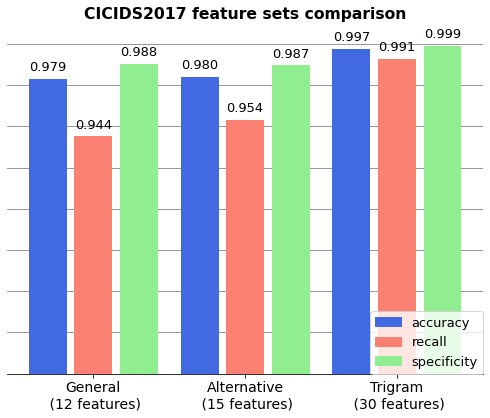

In [8]:
import matplotlib.patches as mpatches

#Scores
genset_acc = 0.979
genset_rec = 0.944
genset_spec = 0.988
trigramset_acc = 0.997
trigramset_rec = 0.991
trigramset_spec = 0.999
altset_acc = 0.980
altset_rec = 0.954
altset_spec = 0.987

#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['General\n (12 features)', 'Alternative\n (15 features)', \
          'Trigram\n (30 features)']

x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [genset_acc,genset_rec,genset_spec,altset_acc,altset_rec,altset_spec,trigramset_acc,trigramset_rec,trigramset_spec]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0], height=scores[1], width=width, color=clr_rec)
plt.bar(x[0]+pad_width, height=scores[2], width=width, color=clr_spec)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width, height=scores[3], width=width, color=clr_acc)
plt.bar(x[1], height=scores[4], width=width, color=clr_rec)
plt.bar(x[1]+pad_width, height=scores[5], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[6], width=width, color=clr_acc)
plt.bar(x[2], height=scores[7], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[8], width=width, color=clr_spec)

#Hide the left, right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
#plt.ylabel('Metric score')
plt.yticks()
ax.set_yticklabels([])
plt.ylim([0.8, 1])
#ax.get_yaxis().set_visible(False)
plt.xticks(size='14')
plt.title("CICIDS2017 feature sets comparison", fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.legend(handles=[acc_patch,rec_patch,spec_patch], loc='lower right', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y', color='grey')
fig.tight_layout()
plt.savefig('cicids2017_binaryclass_featuresets_bars.png',bbox_inches='tight')
plt.show()